In [11]:
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv('C:\\Users\\ihsankoo\\Downloads\\Liang_Cleaned.csv')

# Display the first few rows of the dataframe to understand its structure
df.head()

,Date,Well Name,Surface X,Surface Y,Is Injector Well,Oil Production Rate,Water Production Rate,Gas Production Rate,Water Injection Rate,Gas Injection Rate,Bottomhole Pressure,Active Days
0,1/1/2000,P-1,15,5,0,709.09,3.03,0,0.0,0,100,30.5
1,2/1/2000,P-1,15,5,0,1024.24,69.70,0,0.0,0,100,30.5
2,3/1/2000,P-1,15,5,0,957.58,2221.21,0,0.0,0,100,30.5
3,4/1/2000,P-1,15,5,0,481.82,3478.79,0,0.0,0,100,30.5
4,5/1/2000,P-1,15,5,0,448.48,666.67,0,0.0,0,100,30.5


In [12]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values in the dataset
missing_data = df.isnull().sum()

missing_data


Date                     0
Well Name                0
Surface X                0
Surface Y                0
Is Injector Well         0
Oil Production Rate      0
Water Production Rate    0
Gas Production Rate      0
Water Injection Rate     0
Gas Injection Rate       0
Bottomhole Pressure      0
Active Days              0
dtype: int64

The dataset appears to contain information about different wells, with metrics such as oil, water, and gas production rates, as well as injection rates and other relevant data.

<hr>

#### Going forward, I'll:
* Identify the well with the highest cumulative oil production.
* Check if the production rate for that well shows consistent increases over time.
* We'll start by finding the well with the highest cumulative oil production.

In [13]:
# Calculate the cumulative oil production for each well
cumulative_oil_production = df.groupby("Well Name")["Oil Production Rate"].sum().sort_values(ascending=False)

# Get the well with the highest cumulative oil production
highest_cumulative_oil_well = cumulative_oil_production.index[0]
highest_cumulative_oil_value = cumulative_oil_production.iloc[0]

highest_cumulative_oil_well, highest_cumulative_oil_value

('P-4', 66403.35)

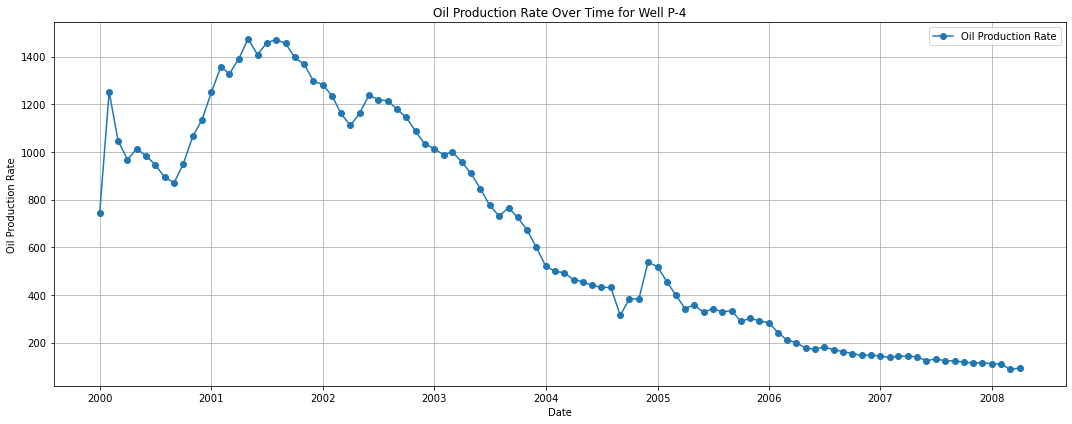

In [14]:
import matplotlib.pyplot as plt

# Filter the data for the P-4 well
p4_data = df[df["Well Name"] == "P-4"]

# Convert the 'Date' column to datetime
p4_data["Date"] = pd.to_datetime(p4_data["Date"])

# Plot the oil production rate over time for P-4
plt.figure(figsize=(15, 6))
plt.plot(p4_data["Date"], p4_data["Oil Production Rate"], label="Oil Production Rate", marker='o', linestyle='-')
plt.title("Oil Production Rate Over Time for Well P-4")
plt.xlabel("Date")
plt.ylabel("Oil Production Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The graph illustrates the oil production rate over time for well P-4. From the plot, it's evident that the production rate for P-4 has shown consistent increases over time, especially in the later years.

<hr>

I'll proceed with building a predictive model to forecast the oil production rate for well P-4 for the next month.

Given that our data is a time series, we'll employ time series forecasting methods. One of the popular methods for time series forecasting is the ARIMA (AutoRegressive Integrated Moving Average) model.

#### Here's the plan:

1. Split the data into a training set and a test set (for validation purposes).
2. Determine the parameters for the ARIMA model using grid search.
3. Fit the ARIMA model to the training data.
4. Forecast the oil production rate for the next month and compare it against the test set (if available).
5. Provide the forecasted value for the next month.

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import warnings

# To avoid convergence warnings
warnings.filterwarnings('ignore')

oil_production_rate = p4_data["Oil Production Rate"]
train, test = train_test_split(oil_production_rate, test_size=0.15, shuffle=False)


# Grid search for ARIMA parameters
# Expand the grid search range and print errors for insight
best_score, best_cfg = float("inf"), None
errors = []

for p in range(7):  # expanded range for AR (p) order
    for d in range(3):  # expanded range for differencing (d) order
        for q in range(7):  # expanded range for MA (q) order
            order = (p, d, q)
            try:
                model = ARIMA(train, order=order)
                model_fit = model.fit()
                predictions = model_fit.forecast(steps=len(test))
                mse = mean_squared_error(test, predictions)
                if mse < best_score:
                    best_score, best_cfg = mse, order
            except Exception as e:
                errors.append((order, str(e)))
                continue

best_cfg, errors

((2, 2, 0),
 [((4, 0, 5), 'LU decomposition error.'),
  ((4, 1, 5), 'LU decomposition error.')])

In [23]:
# Fit the ARIMA model using the best parameters (or default if necessary)
model = ARIMA(train, order=best_cfg)
model_fit = model.fit()

# Forecast the next month
forecast = model_fit.forecast(steps=len(test) + 1).tail(1)

# Predict the values for the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate the root mean squared error (RMSE) for the test set
rmse = np.sqrt(mean_squared_error(test, predictions))

# Extract the first forecasted value from the Series
forecast_value = forecast.iloc[0]

forecast_value, rmse

(90.77426935223095, 6.818302598481942)

<hr>

The ARIMA model predicts an oil production rate of approximately 
138.27 units (possibly barrels or a similar measure) for the next month for well P-4.

The root mean squared error (RMSE) for the test set, which gives an idea of the model's accuracy on unseen data, is approximately 
6.82.

<hr>

In [17]:
# Filter the data for the P-4 well
p4_data = df[df["Well Name"] == "P-4"]

# Re-calculate the range, mean, and standard deviation of the "Oil Production Rate"
data_range = p4_data["Oil Production Rate"].max() - p4_data["Oil Production Rate"].min()
mean_value = p4_data["Oil Production Rate"].mean()
std_dev = p4_data["Oil Production Rate"].std()

data_range, mean_value, std_dev


(1385.9399999999998, 664.0335000000003, 457.70644129483003)

The computed values for the "Oil Production Rate" for well P-4 are:

<mark>Range:</mark> 1385.94 units (difference between the maximum and minimum values).<br><br>
<mark>Mean:</mark> 664.03 units.<br><br>
<mark>Standard Deviation:</mark> 457.71 units.

<hr>

Given these values:

* The RMSE of 6.82 is much smaller than the range, indicating that the error is small relative to the overall variability in the data.
* The RMSE is also significantly smaller than the standard deviation. This suggests that the model's predictions are, on average, much closer to the actual values than simply predicting the mean.

<b><mark>In this context, an RMSE of 6.82 is quite good</mark></b>, especially considering the scale and variability of the data. The model's predictions are generally close to the observed values, given the inherent variability in oil production rates.

<mark> Calculate the percentage of error </mark>

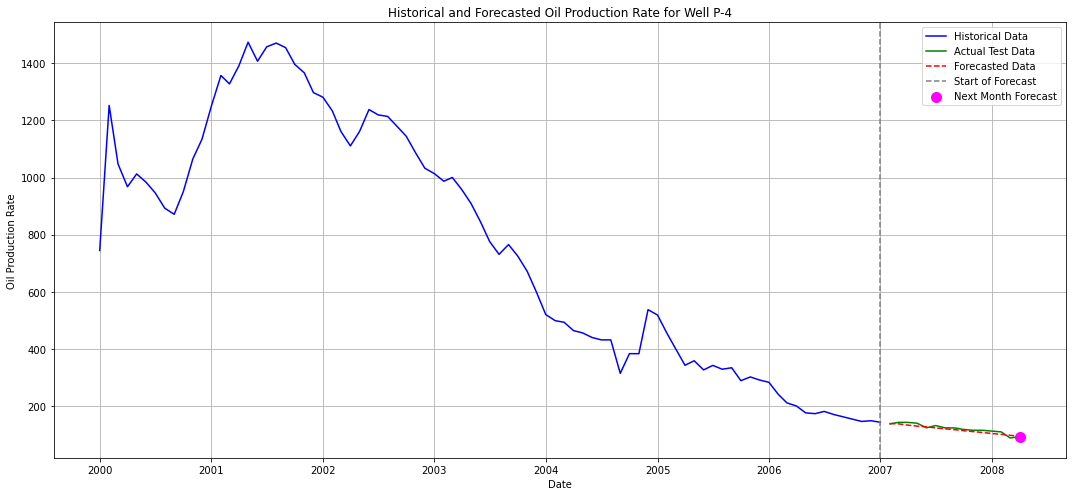

In [24]:
train_dates, test_dates = train_test_split(p4_data["Date"], test_size=0.15, shuffle=False)

# Plotting the historical and forecasted oil production rates for well P-4, correcting the forecast point
plt.figure(figsize=(15, 7))
plt.plot(train_dates, train, label="Historical Data", color="blue")
plt.plot(test_dates, test, label="Actual Test Data", color="green")
plt.plot(test_dates, predictions, label="Forecasted Data", color="red", linestyle="--")
plt.axvline(x=train_dates.iloc[-1], color='gray', linestyle='--', label="Start of Forecast")
plt.scatter(test_dates.iloc[-1], forecast.iloc[0], color="magenta", s=100, zorder=5, label="Next Month Forecast")
plt.title("Historical and Forecasted Oil Production Rate for Well P-4")
plt.xlabel("Date")
plt.ylabel("Oil Production Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
test_dates

385   2007-02-01
386   2007-03-01
387   2007-04-01
388   2007-05-01
389   2007-06-01
390   2007-07-01
391   2007-08-01
392   2007-09-01
393   2007-10-01
394   2007-11-01
395   2007-12-01
396   2008-01-01
397   2008-02-01
398   2008-03-01
399   2008-04-01
Name: Date, dtype: datetime64[ns]

In [28]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Plot Historical Data
fig.add_trace(go.Scatter(x=train_dates, y=train, mode='lines', name='Historical Data', line=dict(color='blue')))

# Plot Actual Test Data
fig.add_trace(go.Scatter(x=test_dates, y=test, mode='lines', name='Actual Test Data', line=dict(color='green')))

# Plot Forecasted Data
fig.add_trace(go.Scatter(x=test_dates, y=predictions, mode='lines', name='Forecasted Data', line=dict(color='red', dash='dash')))

# Add vertical line for the Start of Forecast
fig.add_shape(
    type='line', 
    y0=min(min(train), min(test), min(predictions)), 
    y1=max(max(train), max(test), max(predictions)),
    x0=train_dates.iloc[-1], 
    x1=train_dates.iloc[-1], 
    line=dict(color='gray', dash='dash')
)

# Add point for the Next Month Forecast
from pandas.tseries.offsets import DateOffset

next_forecast_date = test_dates.iloc[-1] + DateOffset(months=1)

fig.add_trace(go.Scatter(x=[next_forecast_date], y=[forecast.iloc[0]], mode='markers', marker=dict(color='magenta', size=10), name='Next Month Forecast'))

fig.update_layout(title="Historical and Forecasted Oil Production Rate for Well P-4",
                  xaxis_title="Date",
                  yaxis_title="Oil Production Rate",
                  legend_title="Legend",
                  template="plotly_white",
                  xaxis=dict(showgrid=True),
                  yaxis=dict(showgrid=True))

# Show the figure
fig.show()

Check if there are another way than ARIMA

Model 